In [4]:
import os 
os.environ['HDF5_DISABLE_VERSION_CHECK']='2'

import keras
keras.__version__

'2.3.1'

# RNN 성능향상

* 순환 드롭아웃 : 순환 층에서 과대적합을 방지하기 위해 케라스에 내장되어 있는 드롭아웃
* 순환 층 스태킹 : 네트워크의 표현 능력을 증가(대신 계산 비용이 많이 듭니다).
* 양방향 순환 층 : 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지

## 기온 예측 문제
독일 예나 시의 막스 플랑크 생물지구화학 연구소( http://www.bgc-jena.mpg.de/wetter/ )의 지상 관측소에서 수집한 날씨데이터

- 2009~2016년 사이의 데이터만 사용
- 기온, 기압, 습도, 풍향 등과 같은 14개의 관측치가 10분마다 기록
- 24시간 이후의 기온을 예측

In [5]:
import os

data_dir = './jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


420,551개 데이터 전체를 넘파이 배열로 변경

In [6]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values   # 원본 데이터 

시간에 따른 기온(섭씨) 그래프

In [7]:
from matplotlib import pyplot as plt

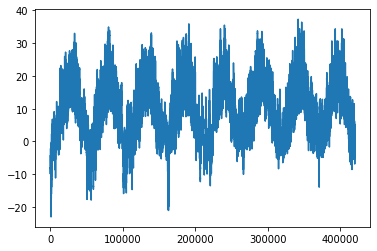

In [8]:
temp = float_data[:, 1]  # 온도(섭씨)
plt.plot(range(len(temp)), temp)
plt.show()

그래프에서 온도에 주기성이 있음

기간을 좁혀서 처음 10일간의 온도 데이터를 나타낸 그래프
 - 10분마다 데이터가 기록되므로 하루에 총 144개의 데이터 포인트가 존재

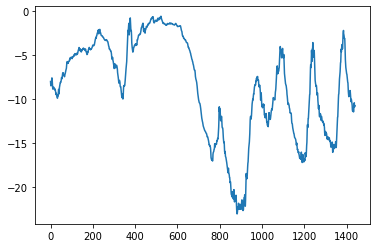

In [10]:
plt.plot(range(1440), temp[:1440])
plt.show()

## Preparing the data

* `lookback = 1440` : 10일 전 데이터로 돌아감
* `steps = 6` : 한 시간마다 데이터 포인트 하나를 샘플링
* `delay = 144` : 24시간이 지난 데이터가 타깃이 됨

시작하기 전에 두 가지 작업

* 각 시계열 특성에 대해 평균을 빼고 표준 편차로 나누어 전처리
* float_data 배열을 받아 과거 데이터의 배치와 미래 타깃 온도를 추출하는 파이썬 제너레이터 작성

처음 200,000개 타임스텝을 훈련 데이터로 사용할 것이므로 전체 데이터에서 200,000개만 사용하여 평균과 표준 편차를 계산

In [11]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

제너레이터 함수의 매개변수(사용자 정의 iterator)

* `data` : 코드 6-32에서 정규화한 부동 소수 데이터로 이루어진 원본 배열
* `lookback` : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
* `delay` : 타깃으로 사용할 미래의 타임스텝
* `min_index`와 `max_index` : 추출할 타임스텝의 범위를 지정하기 위한 `data` 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용합니다.
* `shuffle` : 샘플을 섞을지 시간 순서대로 추출할지 결정
* `batch_size` : 배치의 샘플 수
* `step` : 데이터를 샘플링할 타임스텝 간격. 한 시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정

In [12]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

이제 generator 함수를 사용해 훈련용, 검증용, 테스트용으로 세 개의 제너레이터 작성 

각 제너레이터는 원본 데이터에서 다른 시간대를 사용
- 훈련 제너레이터는 처음 200,000개 타임스텝을 사용
- 검증 제너레이터는 그 다음 100,000개를 사용
- 테스트 제너레이터는 나머지를 사용

In [13]:
lookback = 1440  #10일
step = 6         #1시간
delay = 144      #1일
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 
             - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) 
              - 300001 - lookback) // batch_size

## 상식 수준의 기준점

지금으로부터 24시간 후의 온도는 지금과 동일하다고 예측하는 것입니다.이 방법을 평균 절댓값 오차(MAE)로 평가

```python
np.mean(np.abs(preds - targets))
```

다음은 평가를 위한 반복 루프입니다:

In [14]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [15]:
0.29 * std[1]

2.5672247338393395

출력된 MAE는 0.29입니다. 이 온도 데이터는 평균이 0이고 표준 편차가 1이므로 결괏값이 바로 와 닿지는 않습니다. 평균 절댓값 오차 0.29에 표준 편차를 곱하면 섭씨 2.57°C가 됩니다. 평균 절댓값 오차가 큼

## 기본적인 머신 러닝 방법


In [16]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=
                         (lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 11s 23ms/step - loss: 1.1819 - val_loss: 0.3923
Epoch 2/20
500/500 [==============================] - 12s 24ms/step - loss: 0.4115 - val_loss: 0.2800
Epoch 3/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2993 - val_loss: 0.2121
Epoch 4/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2692 - val_loss: 0.1593
Epoch 5/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2568 - val_loss: 0.2440
Epoch 6/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2475 - val_loss: 0.1707
Epoch 7/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2389 - val_loss: 0.1284
Epoch 8/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2330 - val_loss: 0.1658
Epoch 9/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2287 - val_loss: 0.1945
Epoch 10/20
500/500 [==============================] - 12s 25ms/step - loss: 0.224

## Loss

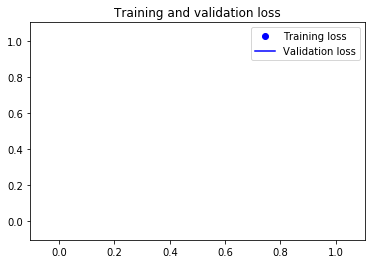

In [27]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## GRU

In [28]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 107s 214ms/step - loss: 0.3034 - val_loss: 0.1558
Epoch 2/20
500/500 [==============================] - 108s 216ms/step - loss: 0.2868 - val_loss: 0.1501
Epoch 3/20
500/500 [==============================] - 108s 216ms/step - loss: 0.2803 - val_loss: 0.1697
Epoch 4/20
500/500 [==============================] - 107s 213ms/step - loss: 0.2742 - val_loss: 0.1335
Epoch 5/20
500/500 [==============================] - 109s 219ms/step - loss: 0.2682 - val_loss: 0.1420
Epoch 6/20
500/500 [==============================] - 108s 216ms/step - loss: 0.2638 - val_loss: 0.1496
Epoch 7/20
500/500 [==============================] - 108s 216ms/step - loss: 0.2588 - val_loss: 0.1737
Epoch 8/20
500/500 [==============================] - 107s 215ms/step - loss: 0.2541 - val_loss: 0.1544
Epoch 9/20
500/500 [==============================] - 107s 214ms/step - loss: 0.2506 - val_loss: 0.1365
Epoch 10/20
500/500 [==============================] - 108s 217m

결과 확인

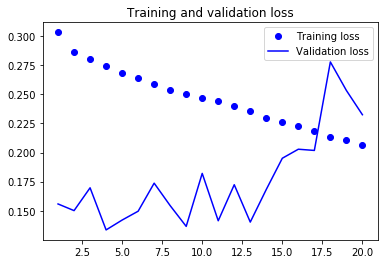

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

시퀀스를 펼쳐서 처리하는 완전 연결 네트워크에 비해서 순환 네트워크가 더 좋은 성능

새로운 검증 MAE는 0.265 이하(크게 과대적합되기 시작하는 곳)이고 정규화되기 전인 섭씨로 복원하면 MAE는 2.35°C입니다. 초기 에러 2.57°C보다는 확실히 낫지만 더 개선의 여지가 있음

## 과대적합을 감소하기 위해 순환 드롭아웃 사용하기

- dropout은 층의 입력에 대한 드롭아웃 비율을 정하는 부동 소수 값
- recurrent_dropout은 순환 상태의 드롭아웃 비율을 정함

In [31]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
106/500 [=====>........................] - ETA: 1:07 - loss: nan

KeyboardInterrupt: 

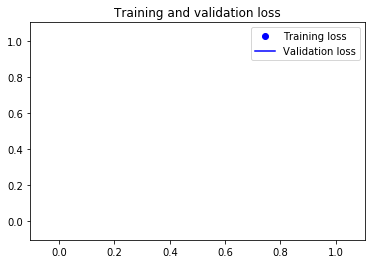

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

30번째 epoch까지 오버피팅이 일어나지 않음. 
평가 점수는 안정적이지만 이전보다 더 나아지지 않음

## 스태킹 순환 층

케라스에서 순환 층을 차례대로 쌓으려면 모든 중간 층은 마지막 타임스텝 출력만이 아니고 전체 시퀀스(3D 텐서)를 출력해야 합니다. `return_sequences=True`로 지정하면 됩니다.

In [22]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
499/500 [============================>.] - ETA: 0s - loss: nan

KeyboardInterrupt: 

In [ ]:
float_data.shape[-1]

In [ ]:
model.summary()

## Loss

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

층을 추가하여 성능을 조금 향상

## 양방향 RNN

입력 시퀀스를 시간 차원을 따라 거꾸로 생성하는 데이터 제너레이터(제너레이터 함수의 마지막 줄을 `yield samples[:, ::-1, :], targets`로 바꿈). 

In [ ]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

순서를 뒤집은 GRU는 상식 수준의 기준점보다도 성능이 낮음

### LSTM IMDB 예제에 적용

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# 특성으로 사용할 단어의 수
max_features = 10000
# 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용)
maxlen = 500

# 데이터 로드
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 시퀀스를 뒤집습니다
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# 시퀀스에 패딩을 추가합니다
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

시간 순서로 훈련한 LSTM과 거의 동일한 성능

양방향 RNN은 성능을 향상시킴

![bidirectional rnn](https://s3.amazonaws.com/book.keras.io/img/ch6/bidirectional_rnn.png)

IMDB 감성 분석 문제에 적용

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

- 여기서 얻은 검증 정확도는 88% 정도로 앞서 사용했던 일반 LSTM보다 조금 더 성능이 높음.
- 이 모델은 조금 더 일찍 과대적합.
- 양방향 순환 층이 단방향 LSTM보다 모델 파라미터가 두 배 많기 때문
- 규제를 조금 추가한다면 양항뱡 순환 층을 사용하는 것이 이 작업에 더 적합

### 동일한 방식을 온도 예측 문제 적용

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

일반 GRU 층과 비슷한 성능